In [1]:
# Importing Libraries
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import colors
from IPython.display import clear_output

# The Environment (Grid-World)

The env.step() function takes as arguments the current state and action, and returns the reward and next state. The appropriate
termination conditions have to be specified by the student in the code (as explained in section 1. env.reset() resets the environment. 

Cell 1: contains the environment class, \\
Cell 2: contains the environment instantiation, and \\
Cell 3: lists some environment variables. \\

For each experiment, the start state is fixed and does not
change. Different experiments may have different start states.

In [2]:
from math import floor
# import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])
class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy array of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.max_steps = 100
        self.r_goal = None
        self.r_restart = None
        self.gamma = 1 # default is no discounting
        self.wind = wind
        self.grid = None
        self.done = False
        self.steps = 0

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # making the gridspace
        self.grid = np.zeros((self.num_rows, self.num_cols))
        for obs in self.obs_states:
            self.grid[obs[0], obs[1]] = 1
        for bad in self.bad_states:
            self.grid[bad[0], bad[1]] = 2
        for restart in self.restart_states:
            self.grid[restart[0], restart[1]] = 3
        for goal in self.goal_states:
            self.grid[goal[0], goal[1]] = 4
        
        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal
        
        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions)) # transition-probability matrix
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):
                        
                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      self.done = False
      self.steps = 0
      return int(self.start_state_seq)
      
    def step(self, state, action):
        p, r = 0, np.random.random()
        self.steps += 1
        for next_state in range(self.num_states):
            
            p += self.P[state, next_state, action]
            
            if r <= p:
                break
        
        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]

          if next_next in self.goal_states_seq or self.steps >= self.max_steps:
            # print("Reached in ", self.steps)
            self.done = True

          return next_next, self.R[next_next], self.done
        else:
          if next_state in self.goal_states_seq or self.steps >= self.max_steps:
            # print("Reached in ", self.steps)
            self.done = True

          return next_state, self.R[next_state], self.done

    '''
    render: render a plot of the environment
    '''
    def render(self, state = None, render_agent = False, ax = None):
        grid = self.grid.copy()
        if render_agent:
            state_ = seq_to_col_row(state, env.num_cols)[0]
            grid[state_[0], state_[1]] = 5
        
        plt.clf()
        if not render_agent:
            cmap = colors.ListedColormap(['#F5E5E1', '#F2D201', '#DB291D', '#AA01F2', '#169E11'])
        elif state is not None:
            cmap = colors.ListedColormap(['#F5E5E1', '#F2D201', '#DB291D', '#AA01F2', '#169E11', '#1DBFDB'])
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 10))
        
        plot = ax.pcolor(grid, cmap=cmap, edgecolors='k', linewidths=2)
        AX = plot.axes
        AX.invert_yaxis()


In [3]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0, 4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = True)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition= 0.7,
                              bias=0.5)
env = gw.create_gridworld()

In [4]:
UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3
actions = [UP, DOWN, LEFT, RIGHT]
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


<Figure size 432x288 with 0 Axes>

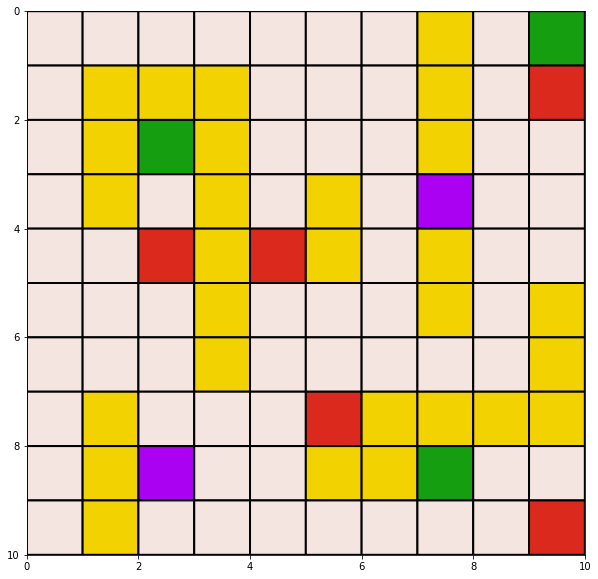

In [5]:
env.render();

**Yellow** - obstruction \\
**Green** - goal state \\
**Red** - bad state \\
**Purple** - restart state \\
**Cyan** - agent

In [6]:
# ploting the Q values
def plot_Q(Q, message = "Q plot"):
    
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [LEFT, RIGHT]:
            return 0
        return 1 if a == UP else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.gca().invert_yaxis()
    plt.show()

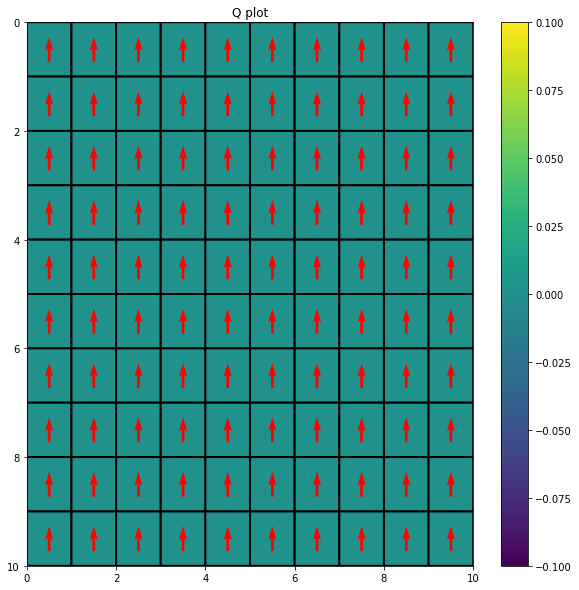

In [7]:
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))

plot_Q(Q)

# Exploration and Exploitation
---
## Epsilon-Greedy & Softmax Algorithms


In [9]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

def choose_action_epsilon(Q, state, epsilon = 0.4, rg=rg):
    p =rg.random()
    state_ = seq_to_col_row(state, env.num_cols)[0]
    if not Q[state_[0], state_[1]].any() or p < epsilon: # TODO: eps greedy condition
        return rg.choice(actions) # TODO: return random action
    else:
        return np.argmax(Q[state_[0], state_[1]]) # TODO: return best action


def choose_action_softmax(Q, state, tau = 0.1, rg=rg):
    state_ = seq_to_col_row(state, env.num_cols)[0]
    return rg.choice(actions, p = softmax(Q[state_[0], state_[1]]/tau))

# SARSA

In [11]:
print_freq = 100

def sarsa(env, Q, episodes = 10000, alpha = 0.1, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax, param = 0.1, rg=rg):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    steps_array = np.zeros((env.num_rows, env.num_cols))
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state, param, rg)
        done = False
        while not done:
            state_next, reward, done = env.step(state, action)
            action_next = choose_action(Q, state_next, param, rg)
            
            state_ = seq_to_col_row(state, env.num_cols)[0] # current state in (row, col) format
            state_next_ = seq_to_col_row(state_next, env.num_cols)[0] # current state in (row, col) format
            

            # TODO: update equation
            Q[state_[0], state_[1], action] += alpha*(reward + \
            gamma * Q[state_next_[0], state_next_[1], action_next] - \
            Q[state_[0], state_[1], action])        
            
            tot_reward += reward
            steps += 1
            steps_array[state_[0], state_[1]] += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion, steps_array

## Epsilon-Greedy Run

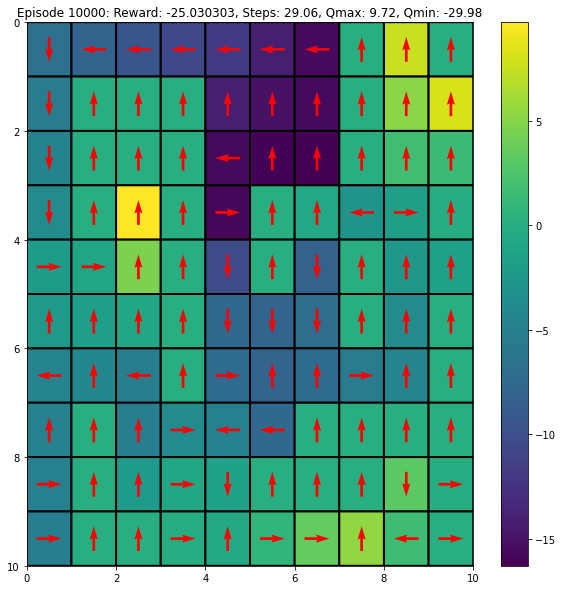

100%|██████████| 10000/10000 [01:04<00:00, 155.86it/s]


In [14]:
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
Q, rewards, steps, steps_array = sarsa(env, Q, 10000, alpha = 0.19, gamma = 0.95, plot_heat=True, choose_action=choose_action_epsilon, param = 0.004)

# Q-Learning

In [12]:
def qlearning(env, Q, episodes = 10000, alpha = 0.1, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax, param = 0.1):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state, param)
        done = False
        while not done:
            state_next, reward, done = env.step(state, action)
            action_next = choose_action(Q, state_next, param)
            
            state_ = seq_to_col_row(state, env.num_cols)[0]
            state_next_ = seq_to_col_row(state_next, env.num_cols)[0]
            # TODO: update equation
            Q[state_[0], state_[1], action]  += alpha*(reward + gamma * np.max(Q[state_next_[0], state_next_[1]]) - \
                                                       Q[state_[0], state_[1], action])                      
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion

## Softmax Run

In [13]:
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
Q, rewards, steps = qlearning(env, Q, 10000, alpha = 1, gamma = 0.9, plot_heat=True, choose_action=choose_action_softmax, param = 0.01)

100%|██████████| 10000/10000 [04:01<00:00, 41.42it/s]


## Epsilon-Greedy Run

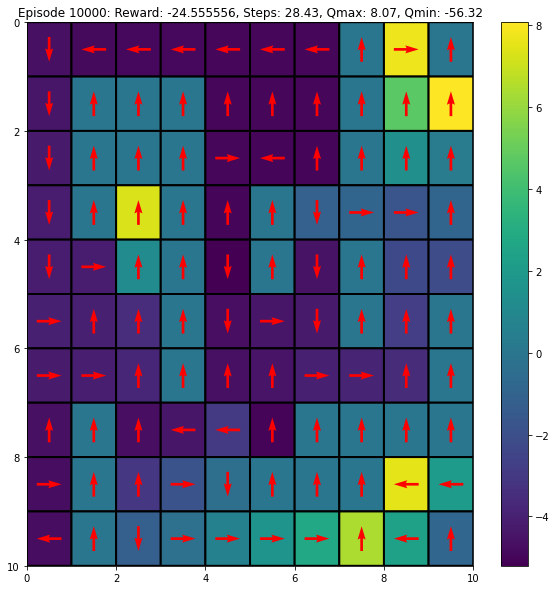

100%|██████████| 10000/10000 [01:18<00:00, 128.05it/s]


In [14]:
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
Q, rewards, steps = qlearning(env, Q, 10000, alpha = 0.15, gamma = 0.8, plot_heat=True, choose_action=choose_action_epsilon, param = 0.005)

# Tuning

In [15]:
epsilon0 = 0.1
alpha0 = 0.1
gamma = 0.9
episodes = 2000

In [16]:
def epsilon_tuning(E_range, E_step, alpha_range, alpha_step, gamma):
    e_val = np.arange(E_range[0], E_range[1], E_step)
    a_val = np.arange(alpha_range[0], alpha_range[1], alpha_step)
    reward = np.zeros((len(e_val), len(a_val)))
    step = np.zeros((len(e_val), len(a_val)))
    print(step)
    row = 0
    for e in e_val:
        col = 0
        for a in a_val:
            Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
            Q, rewards, steps = sarsa(env, Q, episodes=4000, alpha = a, gamma = gamma, plot_heat=True, choose_action=choose_action_epsilon, param = e)
            reward[row, col] = np.mean(rewards)
            step[row, col] = np.mean(steps)
            
            col += 1
        row += 1

    for e in range(len(e_val)):
        for a in range(len(a_val)):
            print(f"epsilon = {e_val[e]}, alpha = {a_val[a]}:", reward[e, a], step[e, a])

    # return reward, step

# Traversal

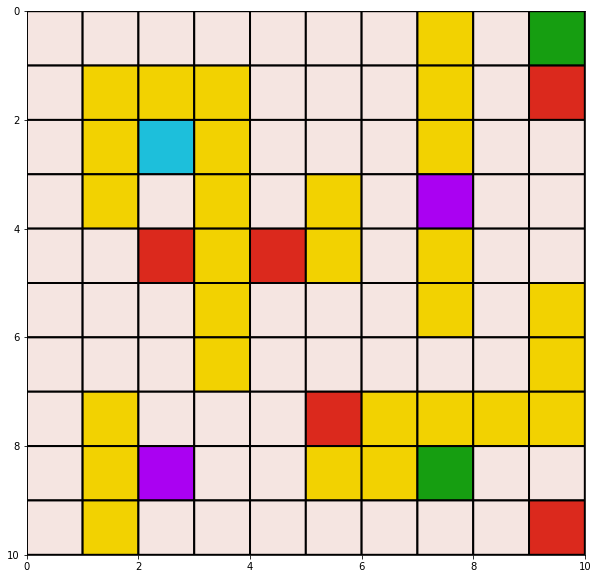

Steps: 73, Total Reward: -67


In [17]:
state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state_ = seq_to_col_row(state, env.num_cols)
    action = choose_action_epsilon(Q, state)
    state, reward, done = env.step(state, action)
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, state=state, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.5)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

# Variations of the Grid World 

In [104]:
start_state = np.array([[0,4]])

gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition= 1,
                              bias=0.5)
env = gw.create_gridworld()

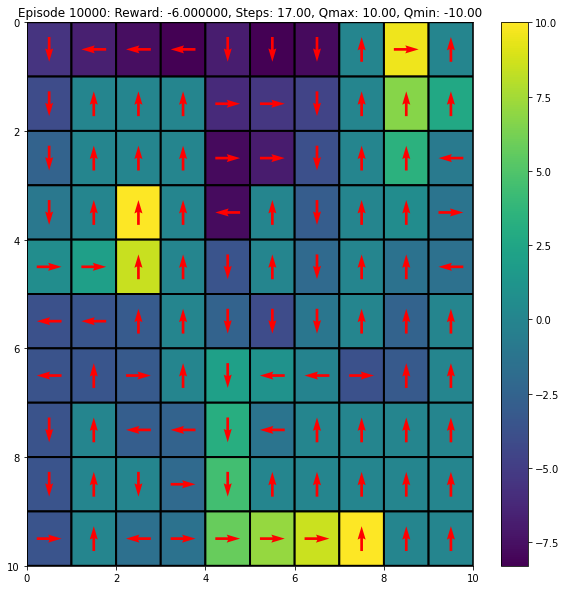

100%|██████████| 10000/10000 [01:14<00:00, 133.72it/s]


In [105]:
# Sarsa epsilon
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
Q, rewards, steps, steps_array = sarsa(env, Q, 10000, alpha = 0.1,
                                       gamma = 0.95, plot_heat=True, 
                                       choose_action=choose_action_softmax, param = 0.001
                                      )

In [25]:
a = np.array([[[1, 1], [1, 1]], [[2, 2], [2, 2]]])
print(np.mean(a, axis=0))
print(np.mean(a, axis=1))
print(np.mean(a, axis=2))

[[1.5 1.5]
 [1.5 1.5]]
[[1. 1.]
 [2. 2.]]
[[1. 1.]
 [2. 2.]]


# PLOTTING FUNCTION


In [106]:
num_expts = 5
num_episodes = 10000
reward_avgs, steps_avgs = [[0 for j in range(num_episodes)] for i in range(2)]
steps_arr_avgs = np.zeros((num_expts, env.num_rows, env.num_cols))

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    rg = np.random.RandomState(i)

    # TODO: run sarsa, store metrics
    Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
    Q, rewards, steps, steps_arr = sarsa(env, Q, num_episodes, alpha = 0.1, 
                                         gamma = 0.95, plot_heat=False, choose_action=choose_action_softmax, 
                                         param = 0.001, rg=rg)
    reward_avgs = [reward_avgs[j]+rewards[j] for j in range(len(rewards))]
    steps_avgs = [steps_avgs[j]+steps[j] for j in range(len(steps))]
    steps_arr_avgs[i] = steps_arr

reward_avgs = [reward_avgs[j]/num_expts for j in range(len(reward_avgs))]
steps_avgs = [steps_avgs[j]/num_expts for j in range(len(steps_avgs))]
steps_arr_avgs = np.mean(steps_arr_avgs, axis=0)

Experiment: 1


100%|██████████| 10000/10000 [00:24<00:00, 413.74it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:22<00:00, 451.76it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:21<00:00, 464.23it/s]


Experiment: 4


100%|██████████| 10000/10000 [00:21<00:00, 460.43it/s]


Experiment: 5


100%|██████████| 10000/10000 [00:23<00:00, 434.38it/s]


In [21]:
def pretty_plotter(Q, rewards_list, steps_list, steps_arr, names=["False", "(0, 4)", "1.0", "softmax"]):
    """    
    Q: Q_value matrix
    rewards_list: rewards for each episode stored in an array
    steps_list: no.of steps taken in each episode stored in an array
    steps_arr: state visit counts matrix
    names[0]: True if there's wind
    names[1]: Start location
    names[2]: Value of p
    names[3]: Exploration strategy used
    """
    fig, ax = plt.subplots(2, 2)
    fig.set_figwidth(15)
    fig.set_figheight(15)
    Qplot = ax[0, 0].pcolor(Q.max(-1), edgecolor='k', linewidth=2)
    def x_direct(a):
        if a in [0, 1]:
            return 0
        return 1 if a == 3 else -1
    def y_direct(a):
        if a in [2, 3]:
            return 0
        return 1 if a == 0 else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    ax[0, 0].quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    ax[0, 0].set_title("Q-values heatmap", fontsize=15)
    plt.colorbar(Qplot, ax=ax[0, 0])
    AxQ = Qplot.axes
    AxQ.invert_yaxis()
    step_map = ax[0, 1].pcolor(steps_arr, edgecolor='k', linewidth=2)
    AxSH = step_map.axes
    AxSH.invert_yaxis()
    ax[0, 1].set_title("Visited states heatmap", fontsize=15)
    plt.colorbar(step_map, ax=ax[0, 1])
    ax[1, 0].plot(rewards_list)
    ax[1, 0].set_title("Total reward over training phase", fontsize=15)
    ax[1, 0].set_ylabel("Total Reward", fontsize=15)
    ax[1, 0].set_xlabel("Episodes", fontsize=15)
    ax[1, 1].plot(steps_list)
    ax[1, 1].set_title("Total steps taken over training phase", fontsize=15)
    ax[1, 1].set_ylabel("Total Steps", fontsize=15)
    ax[1, 1].set_xlabel("Episodes", fontsize=15) 
    fig.suptitle(f"Plots for [wind={names[0]}, start_state: {names[1]}, p={names[2]}, policy: {names[3]}]", fontsize=25)
    plt.show()
    plt.savefig(f"{names[0]}_{names[1]}_{names[2]}_{names[3]}.png")

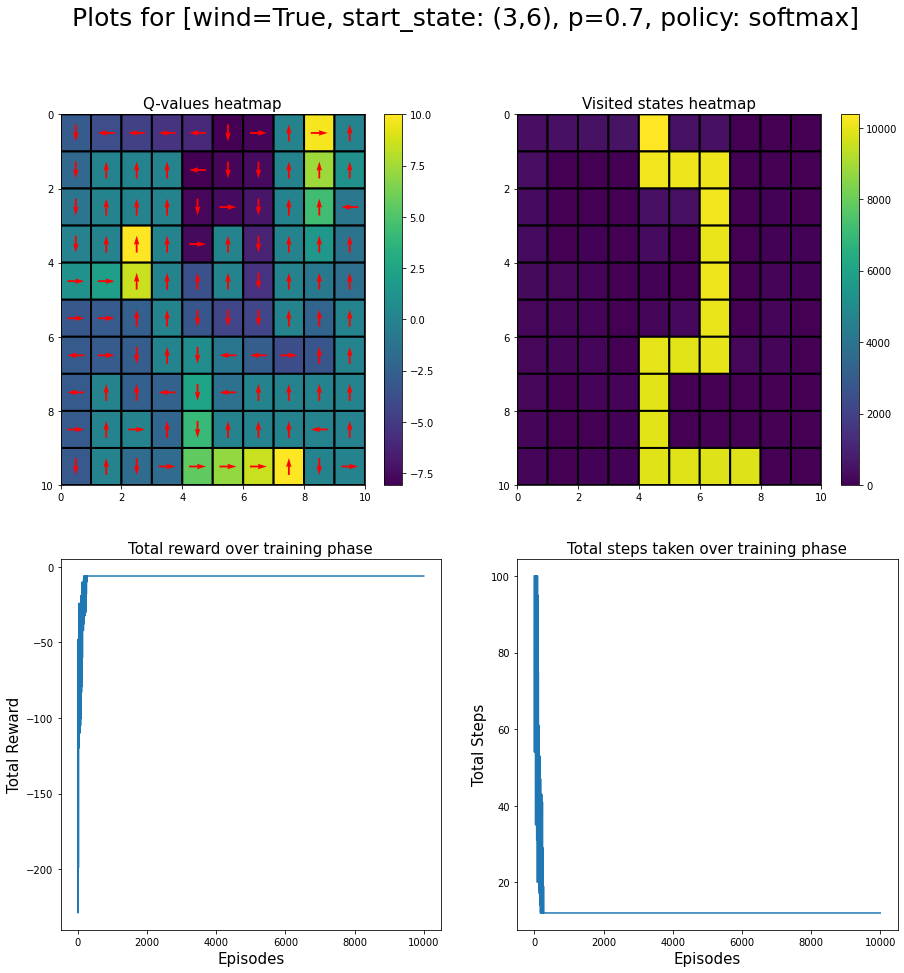

<Figure size 432x288 with 0 Axes>

In [107]:
pretty_plotter(Q, rewards, steps, steps_array, names=["True", "(3,6)", "0.7", "softmax"])